In [1]:
from firedrake import *
from firedrake_adjoint import *

In [2]:
from contexttimer import Timer
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [3]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [4]:
class OptimisationProgress(object):
    def __init__(self):
        self.m_progress = []
        self.J_progress = []
        self.dJdm_progress = []
        self.ls_iteration = 0
        self.feval = 0
        self.geval = 0

Specify 'optimum' and initial guess

In [5]:
m_opt = 5.0
m_prior = 10.0

Create `Options` object and setup gauges.

In [6]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0', '80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())

/home/joe/software/firedrake-pragmatic/src/firedrake/firedrake/parloops.py:130: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


Setup timestepping parameters

In [7]:
num_timesteps = 30
dt = Constant(op.dt)
theta = Constant(0.5)

Create function spaces

In [8]:
mesh = op.default_mesh
P2 = VectorFunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)

Create `Function`s

In [9]:
u, eta = TrialFunctions(V)
test_u, test_eta = TestFunctions(V)
m = Function(R).assign(m_prior)
c = Control(m)
q0 = Function(V)
u0, eta0 = q0.split()
eta0.interpolate(gaussian([(0.7e+06, 4.2e+06, 48e+03, 96e+03)], mesh, rotation=pi/12))
q_ = Function(V)
u_, eta_ = q_.split();

Set physical parameters

In [10]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(9.81)

Setup forward variational problem

In [11]:
a = inner(u, test_u)*dx + eta*test_eta*dx
a += theta*dt*g*inner(grad(eta), test_u)*dx - theta*dt*b*inner(u, grad(test_eta))*dx
L = inner(u_, test_u)*dx + eta_*test_eta*dx
L += -(1-theta)*dt*g*inner(grad(eta_), test_u)*dx + (1-theta)*dt*b*inner(u_, grad(test_eta))*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 100)
problem = LinearVariationalProblem(a, L, q, bcs=bc)

Setup forward variational solver

In [12]:
sp = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}
solver = LinearVariationalSolver(problem, solver_parameters=sp)

Setup QoI

In [13]:
P0 = FunctionSpace(mesh, "DG", 0)
J_form = 0
radius = 20e+03*0.5**level
for gauge in gauges:
    op.gauges[gauge]["data"] = []
    k = Function(P0*P0)
    ku, keta = k.split()
    keta.interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,)], mesh))
    keta.assign(keta/assemble(keta*dx))
    op.gauges[gauge]["indicator"] = keta
    op.gauges[gauge]["obs"] = Function(R)
    op.gauges[gauge]["obs_old"] = Function(R)
    J_form += theta*0.5*dt*keta*(eta - op.gauges[gauge]["obs"])**2*dx
    J_form += (1-theta)*0.5*dt*keta*(eta_ - op.gauges[gauge]["obs_old"])**2*dx

Solve forward to generate 'data'

In [14]:
with stop_annotating():
    u_.assign(u0)
    eta_.project(m_opt*eta0)
    for gauge in gauges:
        op.gauges[gauge]["data"].append(float(eta_.at(op.gauges[gauge]["coords"])))
    for i in range(num_timesteps):
        print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
        solver.solve()
        q_.assign(q)
        for gauge in gauges:
            op.gauges[gauge]["data"].append(float(eta.at(op.gauges[gauge]["coords"])))
    print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")

t =   0.0 min  ||u|| = 0.0000e+00  ||eta|| = 0.0000e+00
t =   1.0 min  ||u|| = 5.2975e+03  ||eta|| = 4.0166e+05
t =   2.0 min  ||u|| = 9.9006e+03  ||eta|| = 3.6750e+05
t =   3.0 min  ||u|| = 1.3447e+04  ||eta|| = 3.2741e+05
t =   4.0 min  ||u|| = 1.5945e+04  ||eta|| = 2.9399e+05
t =   5.0 min  ||u|| = 1.7591e+04  ||eta|| = 2.7287e+05
t =   6.0 min  ||u|| = 1.8619e+04  ||eta|| = 2.6383e+05
t =   7.0 min  ||u|| = 1.9256e+04  ||eta|| = 2.6336e+05
t =   8.0 min  ||u|| = 1.9689e+04  ||eta|| = 2.6755e+05
t =   9.0 min  ||u|| = 2.0066e+04  ||eta|| = 2.7331e+05
t =  10.0 min  ||u|| = 2.0495e+04  ||eta|| = 2.7878e+05
t =  11.0 min  ||u|| = 2.1033e+04  ||eta|| = 2.8348e+05
t =  12.0 min  ||u|| = 2.1702e+04  ||eta|| = 2.8719e+05
t =  13.0 min  ||u|| = 2.2506e+04  ||eta|| = 2.8959e+05
t =  14.0 min  ||u|| = 2.3413e+04  ||eta|| = 2.9162e+05
t =  15.0 min  ||u|| = 2.4402e+04  ||eta|| = 2.9433e+05
t =  16.0 min  ||u|| = 2.5498e+04  ||eta|| = 2.9657e+05
t =  17.0 min  ||u|| = 2.6723e+04  ||eta|| = 2.9

Solve forward to annotate to tape

In [15]:
J = 0
adj_free = 0
u_.assign(u0)
eta_.project(m*eta0)
for i in range(num_timesteps):
    print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
    solver.solve()
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    J = J + assemble(J_form)
    q_.assign(q)
J10 = float(J)
print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
stop_annotating();

t =   0.0 min  ||u|| = 4.5433e+04  ||eta|| = 3.1014e+05
t =   1.0 min  ||u|| = 1.0595e+04  ||eta|| = 8.0331e+05
t =   2.0 min  ||u|| = 1.9801e+04  ||eta|| = 7.3500e+05
t =   3.0 min  ||u|| = 2.6893e+04  ||eta|| = 6.5482e+05
t =   4.0 min  ||u|| = 3.1889e+04  ||eta|| = 5.8797e+05
t =   5.0 min  ||u|| = 3.5181e+04  ||eta|| = 5.4574e+05
t =   6.0 min  ||u|| = 3.7239e+04  ||eta|| = 5.2766e+05
t =   7.0 min  ||u|| = 3.8512e+04  ||eta|| = 5.2673e+05
t =   8.0 min  ||u|| = 3.9378e+04  ||eta|| = 5.3510e+05
t =   9.0 min  ||u|| = 4.0131e+04  ||eta|| = 5.4663e+05
t =  10.0 min  ||u|| = 4.0990e+04  ||eta|| = 5.5757e+05
t =  11.0 min  ||u|| = 4.2066e+04  ||eta|| = 5.6697e+05
t =  12.0 min  ||u|| = 4.3405e+04  ||eta|| = 5.7437e+05
t =  13.0 min  ||u|| = 4.5011e+04  ||eta|| = 5.7917e+05
t =  14.0 min  ||u|| = 4.6827e+04  ||eta|| = 5.8323e+05
t =  15.0 min  ||u|| = 4.8805e+04  ||eta|| = 5.8867e+05
t =  16.0 min  ||u|| = 5.0997e+04  ||eta|| = 5.9314e+05
t =  17.0 min  ||u|| = 5.3447e+04  ||eta|| = 5.9

Create `ReducedFunctional` and compute gradient using discrete adjoint

In [16]:
op = OptimisationProgress()

In [17]:
def f_cb(j, ctrl):
    op.feval += 1

In [18]:
def g_cb(j, djdm, ctrl):
    op.geval += 1
    op.J = j
    op.dJdm = djdm.dat.data[0]
    op.m = ctrl.dat.data[0]

In [19]:
def cb(ctrl):
    op.ls_iteration += 1
    print(f"{op.ls_iteration:4d}  {op.m:7.4}  {op.J:.8}  {op.dJdm:.8}")
    op.m_progress.append(op.m)
    op.J_progress.append(op.J)
    op.dJdm_progress.append(op.dJdm)

In [20]:
Jhat = ReducedFunctional(J, c, eval_cb_post=f_cb, derivative_cb_post=g_cb)

In [21]:
c.update(10.0)
op.__init__()
with Timer() as t:
    m_opt = minimize(Jhat, method='BFGS', callback=cb)
print(f"CPU time: {t}s, {op.feval} function evaluations, {op.geval} gradient evaluations, {op.ls_iteration} line searches")

   1     8.99  6041.5815  1775.2002
   2    6.739  2964.1631  959.64815
   3    4.091  1693.5139  4.9185049e-05
   4    4.091  1693.5139  -3.9546262e-11
CPU time: 41.044s, 5 function evaluations, 5 gradient evaluations, 4 line searches


## Performance

|      Mesh      | feval | geval | LS |   Run 1   |   Run 2   |   Run 3   |   Run 4   |  Average  |
| -------------- | ----- | ----- | -- | --------- | --------- | --------- | --------- | --------- |
| $\mathcal H_0$ |   5   |   5   |  4 |   41.079  |   40.874  |   41.121  |   40.431  |   40.876  |
| $\mathcal H_1$ |   4   |   4   |  3 |   68.732  |   62.334  |   61.149  |   66.228  |   64.611  |
| $\mathcal H_2$ |   4   |   4   |  3 |  200.144  |  193.300  |  183.171  |  190.668  |  191.820  |

In [22]:
l = si.lagrange(op.m_progress[:3], op.J_progress[:3])
dl = l.deriv()
l_min = -dl.coefficients[1]/dl.coefficients[0]
print("Minimiser of quadratic: {:.4f}".format(l_min))

Minimiser of quadratic: 4.0913


Plot progress of optimisation

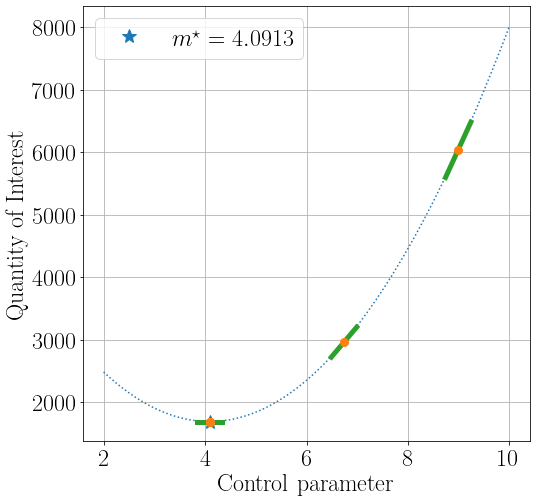

In [23]:
fig, axes = plt.subplots(figsize=(8, 8))
xx = np.linspace(2, 10, 100)
axes.plot(xx, l(xx), ':', color='C0')
axes.plot(l_min, l(l_min), '*', markersize=14, color='C0', label=r"$m^\star={:.4f}$".format(l_min))

delta_m = 0.25
for i, (mi, fi, gi) in enumerate(zip(op.m_progress, op.J_progress, op.dJdm_progress)):
    x = np.array([mi - delta_m, mi + delta_m])
    axes.plot(x, gi*(x - mi) + fi, '-', color='C2', linewidth=5)
axes.plot(op.m_progress, op.J_progress, 'o', color='C1', markersize=8)

axes.set_xlabel("Control parameter")
axes.set_ylabel("Quantity of Interest")
axes.grid(True)
axes.legend();
plt.savefig(f"plots/tohoku1d_inversion_discrete_{level}.pdf")

Minimisers for $\theta=\frac12$: 4.0913, 4.7927, 4.9221.